# Big Data Platforms

## Pyspark Machine Learning 

### Chicago Food Inspection 

This notebook demonstrates the use of PySpark dataframe APIs and Spark SQL

**Dataset:**
https://www.kaggle.com/chicago/chi-restaurant-inspections

Copyright: 2018 [Ashish Pujari](apujari@uchicago.edu)

In [1]:
#spark sql imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#spark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
spark = SparkSession.builder.appName('ChicagoFoodInspectionML').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.driver.memory', '4g'),
 ('spark.executor.memory', '4g'),
 ('spark.driver.port', '51457'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.cores', '4'),
 ('spark.cores.max', '4'),
 ('spark.driver.host', 'DESKTOP-RV4I2EU'),
 ('spark.app.name', 'Spark Updated Conf'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1550454083897'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

Read dataset from CSV file

## Data Exploration

In [4]:
df = spark.read.csv("T:\\courses\\BigData\\data\\chicago-food-inspections\\food-inspections.csv", inferSchema=True, header=True)

In [5]:
df.printSchema()

root
 |-- Inspection ID: integer (nullable = true)
 |-- DBA Name: string (nullable = true)
 |-- AKA Name: string (nullable = true)
 |-- License #: integer (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Risk: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- Inspection Date: timestamp (nullable = true)
 |-- Inspection Type: string (nullable = true)
 |-- Results: string (nullable = true)
 |-- Violations: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [6]:
df = df.dropna()

In [7]:
#Count results by result type 
df2 = df.groupby("Results").count()
df2.show()

+------------------+-----+
|           Results|count|
+------------------+-----+
|         Not Ready|   31|
|              Fail|30889|
|          No Entry|  403|
|Pass w/ Conditions|18849|
|   Out of Business|   23|
|              Pass|78399|
+------------------+-----+



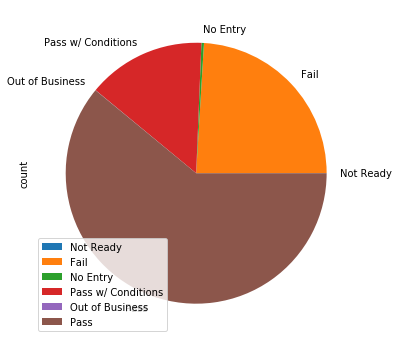

In [8]:
resultsdf = df2.toPandas()
resultsdf.plot.pie(y='count', labels = resultsdf['Results'], figsize=(6, 6))

## Classification

In [9]:
#convert Results to numerical categories
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
    
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = df.select(label(df.Results).alias('label'), df.Violations).where('label >= 0')

In [10]:
labeledData.show(10)

+-----+--------------------+
|label|          Violations|
+-----+--------------------+
|  1.0|3. MANAGEMENT, FO...|
|  1.0|3. MANAGEMENT, FO...|
|  1.0|3. MANAGEMENT, FO...|
|  1.0|3. MANAGEMENT, FO...|
|  1.0|3. MANAGEMENT, FO...|
|  1.0|3. MANAGEMENT, FO...|
|  1.0|3. MANAGEMENT, FO...|
|  0.0|2. CITY OF CHICAG...|
|  1.0|3. MANAGEMENT, FO...|
|  1.0|3. MANAGEMENT, FO...|
+-----+--------------------+
only showing top 10 rows



*HashingTF* utilizes the hashing trick. A raw feature is mapped into an index (term) by applying a hash function. The hash function used here is [MurmurHash3](https://en.wikipedia.org/wiki/MurmurHash). Then term frequencies are calculated based on the mapped indices. This approach avoids the need to compute a global term-to-index map, which can be expensive for a large corpus, but it suffers from potential hash collisions, where different raw features may become the same term after hashing.

In [11]:
tokenizer = Tokenizer(inputCol="Violations", outputCol="words")

#Maps a sequence of terms to their term frequencies using the hashing trick. 
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")

In [12]:
#Logistic Regression Model
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

In [13]:
#split data into train and test
train_df, test_df = pipeline.randomSplit([.8,.2],seed=1234)
train_df.show(1)

+-----+--------------------+
|label|          Violations|
+-----+--------------------+
|  0.0|1. PERSON IN CHAR...|
+-----+--------------------+
only showing top 1 row



In [14]:
model = pipeline.fit(train_df)

In [15]:
# Predict each point's label and show the results.
predictions = model.transform(test_df)
predictions.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|          Violations|               words|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[3451,408...|[7.24005837136300...|[0.99928324421647...|       0.0|
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[1536,337...|[14.1298073817789...|[0.99999926969830...|       0.0|
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[3618,408...|[-0.9887247141243...|[0.27116404406787...|       1.0|
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[1011,208...|[3.17449270271119...|[0.95986302846787...|       0.0|
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[1957,208...|[14.2387599663717...|[0.99999934508515...|       0.0|
+-----+-

### Classifier Evaluation

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.9404281967983091
0.9395292453751324


## Cross Validation

In [17]:
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_df)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
predictions = cvModel.transform(test_df)

In [18]:
predictions.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|          Violations|               words|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[3451,408...|[7.24005837136300...|[0.99928324421647...|       0.0|
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[1536,337...|[14.1298073817789...|[0.99999926969830...|       0.0|
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[3618,408...|[-0.9887247141243...|[0.27116404406787...|       1.0|
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[1011,208...|[3.17449270271119...|[0.95986302846787...|       0.0|
|  0.0|1. PERSON IN CHAR...|[1., person, in, ...|(262144,[1957,208...|[14.2387599663717...|[0.99999934508515...|       0.0|
+-----+-

In [20]:
#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.9389408587420252
0.9375945947555683
